#2 Dimension Square Separation #

In this notebook I was able to separate two overlapping squares

#Log Likelihood#

We want to look for the log likelihood of producing the dataset $ \mathcal{D} $ for a given image from dreams of the image. Wait the dreams? Or should I look at the reconstructions? For looking at the RBM I should be able to get away with a reconstruction
$$ LL_{\mathcal{D}} = \sum_{i} v_i \log( \sigma_i) + (1 - v_i) \log(1 - \sigma_i)  $$

$$
\log P\big(v\big|h_{a}\big)  = \begin{cases}
\log( \sigma_i) & \text{if $v_i=1$}\\
\log(1 - \sigma_i) & \text{if $v_i = 0$}
\end{cases}
$$


In [1]:
from scipy.special import expit
from rbmpy.rbm import RBM
from rbmpy.sampler import VanillaSampler, PartitionedSampler, ApproximatedSampler, LayerWiseApproxSampler,ApproximatedMulDimSampler, ContinuousSampler
from rbmpy.trainer import VanillaTrainier
from rbmpy.performance import Result
import numpy as np
import rbmpy.datasets, rbmpy.performance, rbmpy.plotter, rbmpy.mnist, pickle, rbmpy.rbm, os, logging, rbmpy.sampler,math
from sklearn.linear_model import Perceptron
from sklearn.neural_network import BernoulliRBM
import rbmpy.plotter as pp
from numpy import newaxis
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

logger = logging.getLogger()
# Set the logging level to logging.DEBUG 
logger.setLevel(logging.INFO)


%matplotlib inline
from IPython.core.debugger import Tracer; debug_here = Tracer()
# Helper Methods
def squash_images(imgs):
    squashed = np.array(imgs)
    old_shape = squashed.shape
    squashed = squashed.reshape(old_shape[0], old_shape[1] * old_shape[2])
    return squashed

def inflate_images(imgs):
    inflated = np.array(imgs)
    old_shape = inflated.shape
    size= math.sqrt(old_shape[1])
    inflated = inflated.reshape(old_shape[0], size, size)
    return inflated
def gen_square(xy,sq_shape, img_size):
    """Square image starting at i, of sq_size within img_size. i must be < (sq_size + img_size)"""
    img = np.zeros(img_size)
    x = xy[0]
    y = xy[1]
    x2 = x + sq_shape[0]
    y2 = y + sq_shape[1]
    img[x:x2,y:y2] = 1
    return img

def gen_training(sq_shape, img_size):
    if img_size[0] != img_size[1]:
        logger.warn("Unsquashing will not work with none squares yet!")
    training = []
    for x in range(img_size[0]- 1):
        for y in range(img_size[1]-1):
            training.append(gen_square((x,y), sq_shape, img_size))
    return np.array(training)
    
def ll_score(v, v_prime):
    if v == 1:
        return np.log(v_prime)
    elif v == 0:
        return np.log(1 - v_prime)
    else:
        raise NotImplementedError()
ll_score = np.vectorize(ll_score)

def evaluate_model(training, model):
    s = VanillaSampler(model)
    results = []
    avg = 0
    for i in range(5000):
        results.append(ll_score(squash_images(train),s.reconstruction_given_visible(squash_images(train), return_sigmoid=True)).sum())
    avg = avg/i
    npr = np.array(results)
    return npr
   # return np.median(npr,axis=0), np.min(npr, axis = 0), np.max(npr,axis = 0), np.mean(npr,axis = 0)
    
    
def plot_eval(train,model):
    # look at the reconstructions
    dreams = []
    for i in range(16):
        dreams.append(s.dream(model).reshape(5,5))
    pp.images(np.array(dreams))
    # Lets also look at it's weights
    pp.images(rbmpy.rbm.weights_into_hiddens(model.weights)[:10], cmap='Greys',title= "Hinton Diagrams",filename="Results/Weights.png")
    result = evaluate_model(train,model)
    plt.plot(result)
    plt.show()
    print("mean{:.2f} Worst {:.2f} Best {:.2f}".format( np.mean(result), np.min(result), np.max(result)))
    pp.images(inflate_images(squash_images(train) - s.reconstruction_given_visible(squash_images(train))))

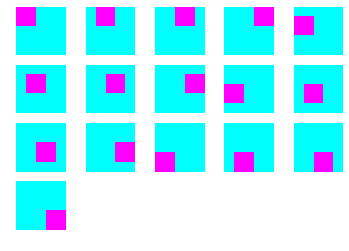

In [2]:
train = gen_training((2,2),(5,5))
# np.random.shuffle(train)
pp.images(train, title="Training Set", filename="Results/Training.png")

# Train and Evaluate the Traditional Model

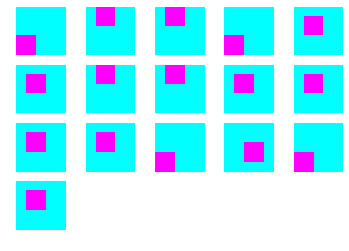

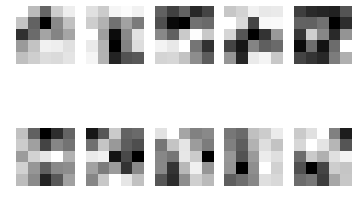

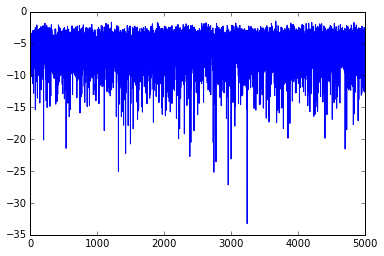

mean-6.14 Worst -33.24 Best -1.49


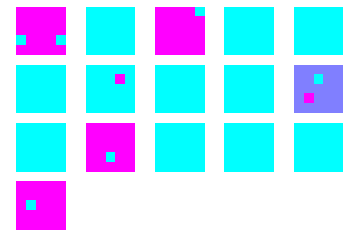

In [12]:
model = RBM(25,25,16)
s = VanillaSampler(model)
t = VanillaTrainier(model, s)
t.train(200, squash_images(train), learning_rate=0.05, use_visible_bias = False)
# plot the 16 centers
plot_eval(train, model)

# Make the sampler and random Composite #

In [70]:
help(s.dream)

Help on method dream in module rbmpy.sampler:

dream(model, num_gibbs=1000, return_sigmoid=False) method of rbmpy.sampler.VanillaSampler instance
    # now I should look at the dreams and see if they are kosher



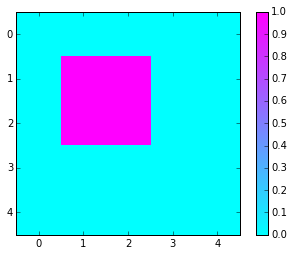

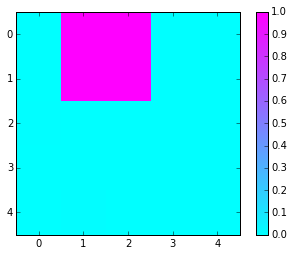

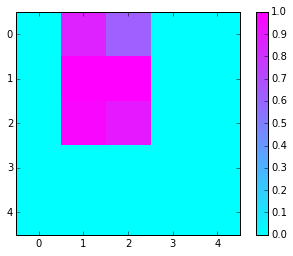

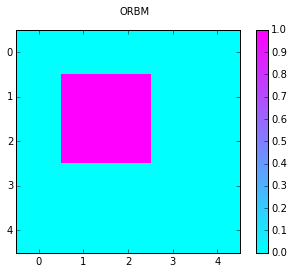

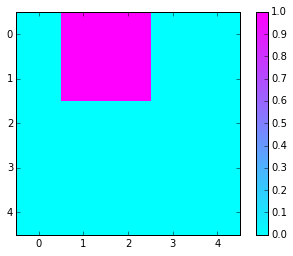

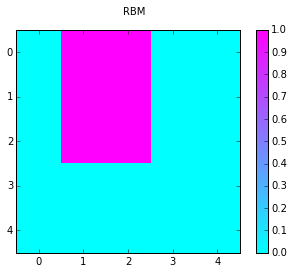

In [22]:
s = VanillaSampler(model)
dream1 = s.dream(model, num_gibbs = 500)
dream2 = s.dream(model, num_gibbs = 500)

phi_1 = np.dot(s.visible_to_hidden(dream1), model.weights)  
phi_2 = np.dot(s.visible_to_hidden(dream2), model.weights) 
pp.image(expit(phi_1).reshape(5,5))
pp.image(expit(phi_2).reshape(5,5))
# pp.image((expit(phi_1) + expit(phi_2)).reshape(5,5))
comp = expit(phi_1 + phi_2)
pp.image(comp.reshape(5,5))


orbm_sampler = ApproximatedSampler(model.weights,model.weights,model.hidden_bias, model.hidden_bias)


rand_h = np.random.randint(0,2,size=( model.num_hid())) 

left, right =  orbm_sampler.v_to_v(rand_h,rand_h, comp)
plt.suptitle("ORBM")
pp.image(left.reshape(5,5))
pp.image(right.reshape(5,5))
rbm_sampler = VanillaSampler(model)
plt.suptitle("RBM")
pp.image(rbm_sampler.reconstruction_given_visible(comp).reshape(5,5))

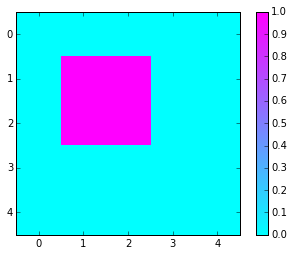

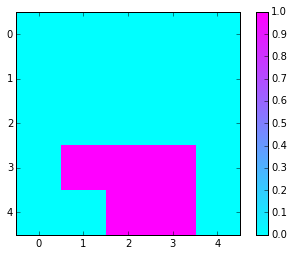

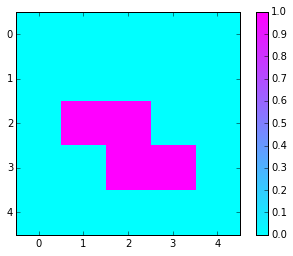

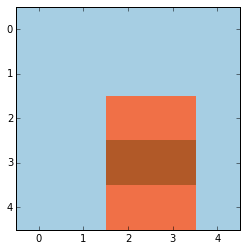

In [155]:
a = ApproximatedMulDimSampler(model.weights,model.weights, model.hidden_bias,model.hidden_bias)
data = model.visible.copy()
np.random.shuffle(data)
item_one = inflate_images(data)[0]
item_two = inflate_images(data)[1]
composite_v = np.maximum(item_one,item_two )
pp.image(item_one+ item_two,cmap='Paired',show_colorbar=False)

In [6]:
rand_h = np.random.randint(0,2,10)
approx= ApproximatedSampler(model.weights, model.weights, model.hidden_bias, model.hidden_bias)
reconstruction = approx.v_to_v(rand_h,rand_h, composite_v.reshape(25),num_gibbs=500)
pp.image(reconstruction[0].reshape(5,5),show_colorbar=False, title="V'_a")
pp.image(reconstruction[1].reshape(5,5), show_colorbar=False, title = "V'_b" )
pp.image(reconstruction[0].reshape(5,5) + reconstruction[1].reshape(5,5),title="Composite Recon" ,cmap ='Paired',show_colorbar=False)
pp.image(s.reconstruction_given_visible(composite_v.reshape(25)).reshape(5,5),show_colorbar=False)

NameError: name 'composite_v' is not defined

# Make a composite training set #

In [150]:
def gen_composite_training(sq_shape, img_size, static_xy):
    training = []
    for x in range(img_size[0]-1):
        for y in range(img_size[1]-1):
            training.append(np.maximum(gen_square((x,y), sq_shape, img_size),gen_square(static_xy, sq_shape, img_size)))
    return np.array(training)

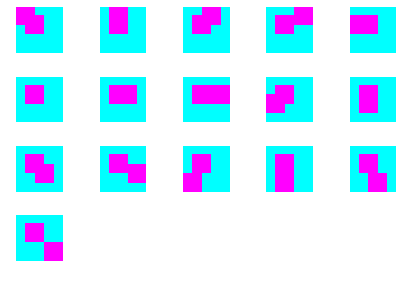

In [151]:
comp = gen_composite_training((2,2),(5,5),(1,1))
pp.images(comp)

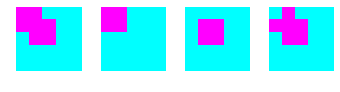

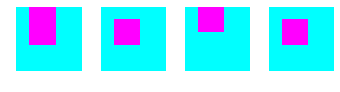

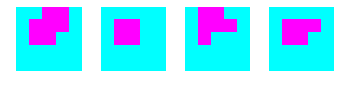

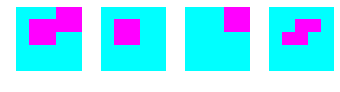

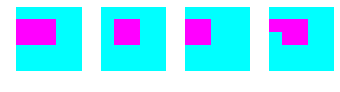

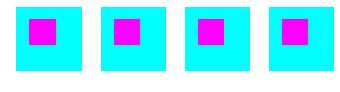

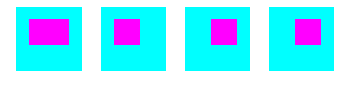

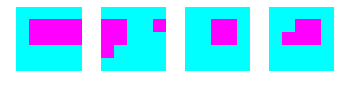

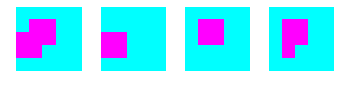

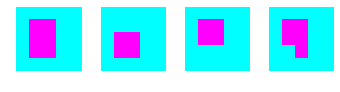

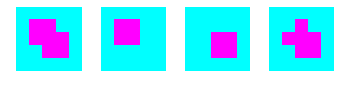

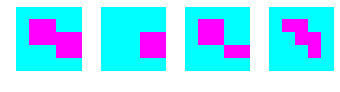

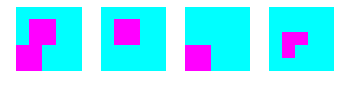

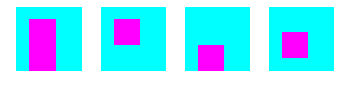

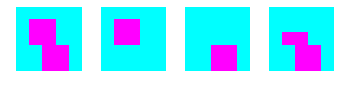

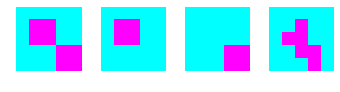

In [152]:
rand_h = np.random.randint(0,2,35)
approx= ApproximatedSampler(model.weights, model.weights, model.hidden_bias, model.hidden_bias)

for current_img in comp:
    reconstruction = approx.v_to_v(rand_h,rand_h,current_img.reshape(25),num_gibbs=1000)
    pp.images(np.array([current_img,reconstruction[0].reshape(5,5), reconstruction[1].reshape(5,5), s.reconstruction_given_visible(current_img.reshape(25)).reshape(5,5)]))